<center><h1>1-ab: Introduction to Neural Networks</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [ ]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
!unzip -j 2-ab.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-ab/utils-data.py

--2024-10-29 16:31:29--  https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip [following]
--2024-10-29 16:31:30--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13423991 (13M) [application/zip]
Saving to: ‘2-ab.zip’

2-ab.zip            100%[===================>]  12.80M  --.-KB/s    in 0.1s    

2024-10-29 16:31:30 (113 MB/s) - ‘2-ab.zip’ saved [13423991/13423991]

Archive:  2-ab.zip
  inflating: ._2-ab            

In [ ]:
import math
import torch
from torch.autograd import Variable
import numpy as np
from numpy import random
import matplotlib
import matplotlib.pyplot as plt
%run 'utils-data.py'

# Part 1 : Forward and backward manuals

In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    params["Wh"] = torch.randn(nh, nx) *0.3 # we multiply by 0.3 to have a std of 0.3
    params["Wy"] = torch.randn(ny, nh) *0.3
    params["bh"] = torch.randn(1,nh) *0.3
    params["by"] = torch.randn(1,ny) *0.3

    return params

In [ ]:
def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    """
    bsize = X.size(0)
    nh = params['Wh'].size(0)
    ny = params['Wy'].size(0)
    outputs = {}

    # fill values for X, htilde, h, ytilde, yhat

    outputs["X"] = X
    outputs["htilde"] = torch.mm(outputs['X'], params["Wh"].T) + params['bh']
    outputs["h"] = torch.tanh(outputs["htilde"])
    outputs["ytilde"] = torch.mm(outputs['h'], params["Wy"].T) + params['by']
    outputs["yhat"] = torch.nn.functional.softmax(outputs["ytilde"], dim=1)

    return outputs['yhat'], outputs

In [ ]:
# Test
N=10
nx=3
nh=4
ny=2
params=init_params(nx, nh, ny)
X = torch.randn(N, nx)
y= torch.nn.functional.one_hot(torch.tensor([1,0,0,1,1,1,0,0,1,1]), num_classes=2)
yhat, outputs = forward(params, X)
print()
print(torch.sum(outputs["yhat"], dim=1))


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [ ]:
outputs["yhat"]

tensor([[0.4090, 0.5910],
        [0.5798, 0.4202],
        [0.7281, 0.2719],
        [0.5885, 0.4115],
        [0.5528, 0.4472],
        [0.4391, 0.5609],
        [0.4791, 0.5209],
        [0.5388, 0.4612],
        [0.2930, 0.7070],
        [0.3296, 0.6704]])

In [ ]:
def loss_accuracy(Yhat, Y):
    # We assume that Y dim = (N,ny)
    Yhat= Yhat.reshape(Y.shape[0], Y.shape[1])
    L = 0
    acc = 0

    # Loss function
    L= -torch.sum(Y * torch.log(Yhat))

    # Accuracy
    _, indsYhat = torch.max (Yhat, 1) # dim=1; so we get the same number of exemples
    _, indsY = torch.max (Y, 1)
    acc = torch.sum(indsYhat==indsY)/indsYhat.shape[0]
    return L, acc

# Test
loss_accuracy(outputs["yhat"], y)

(tensor(5.7604), tensor(0.7000))

In [ ]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    # We assume that Y dim = (N,ny)
    Yhat= outputs['yhat'].reshape(Y.shape[0], Y.shape[1])

    grad_y_tild= Yhat - Y
    H= outputs["h"]
    ones=torch.ones(H.shape)
    grad_h_tild= torch.mul(torch.mm(grad_y_tild, params['Wy']), (ones - H**2))

    # fill values for Wy, Wh, by, bh
    grads["Wy"] = torch.mm(grad_y_tild.T, H)
    grads["Wh"] = torch.mm(grad_h_tild.T, outputs['X'])
    grads["by"] = torch.sum(grad_y_tild, dim=0)
    grads["bh"] = torch.sum(grad_h_tild, dim=0)
    return grads

In [ ]:
def sgd(params, grads, eta):

    params["Wh"] = params["Wh"] - eta*grads["Wh"]
    params["Wy"] = params["Wy"] - eta*grads["Wy"]
    params["bh"] = params["bh"] - eta*grads["bh"]
    params["by"] = params["by"] - eta*grads["by"]

    return params

## Global learning procedure "by hands"

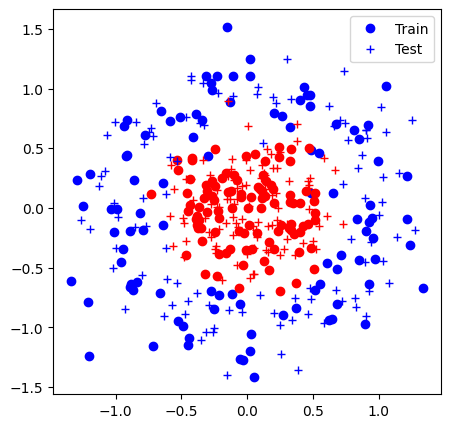

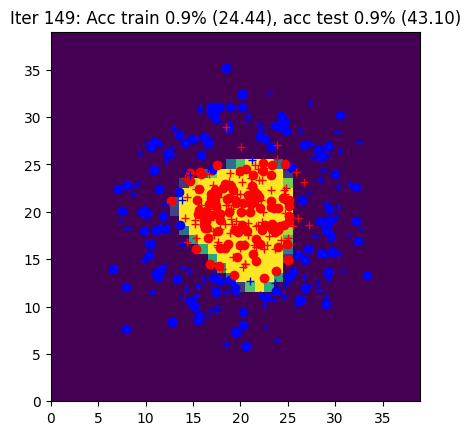

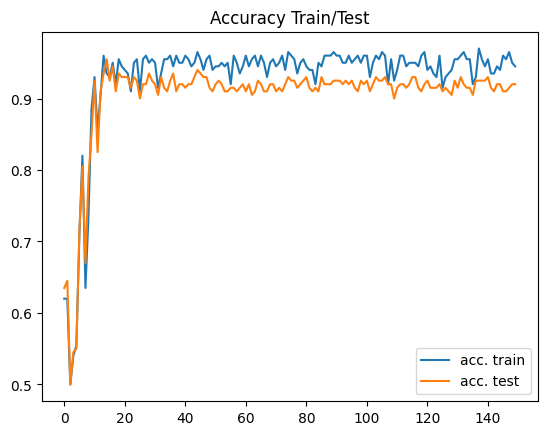

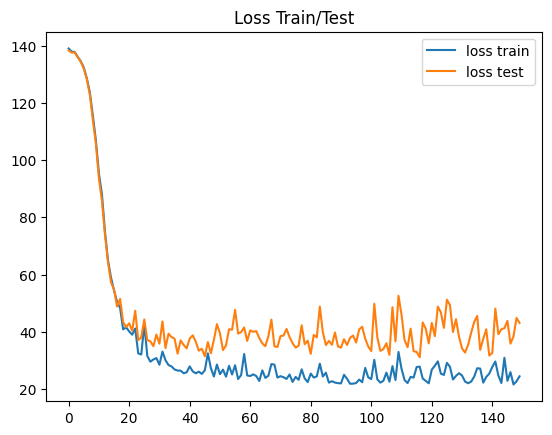

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

nb_epoch= 150

# epoch
for iteration in range(nb_epoch):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, backward, sgd
        Yhat, outputs= forward(params, X)

        L, acc= loss_accuracy(Yhat, Y)

        grads= backward(params, outputs, Y)
        params= sgd(params, grads, eta)


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    # print(title)
    #data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

data.plot_data_with_grid(Ygrid, title)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Accuracy Train/Test")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss Train/Test")
plt.legend()
plt.show()

In [ ]:
print( "Accuracy train : ", curves[0][-1].item()*100, "%")
print( "Accuracy test : ", curves[1][-1].item()*100, "%")
print( "Loss train : ", curves[2][-1].item())
print( "Loss test : ", curves[3][-1].item())

Accuracy train :  94.49999928474426 %
Accuracy test :  92.00000166893005 %
Loss train :  24.43614387512207
Loss test :  43.09955978393555


## Experiments on the learning rate and the batch size

Learning Rate: 0.01, Batch Size: 20


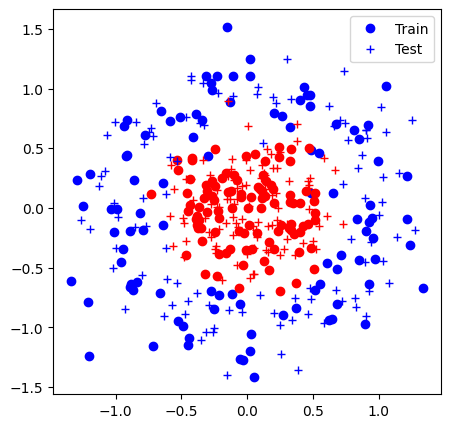

Learning Rate: 0.01, Batch Size: 10


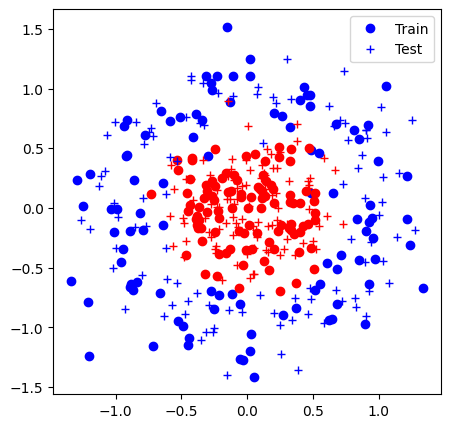

Learning Rate: 0.01, Batch Size: 5


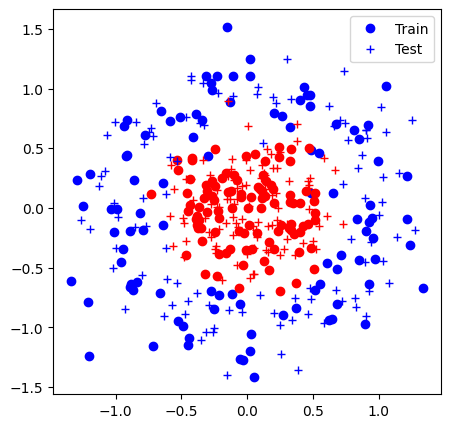

Learning Rate: 0.1, Batch Size: 20


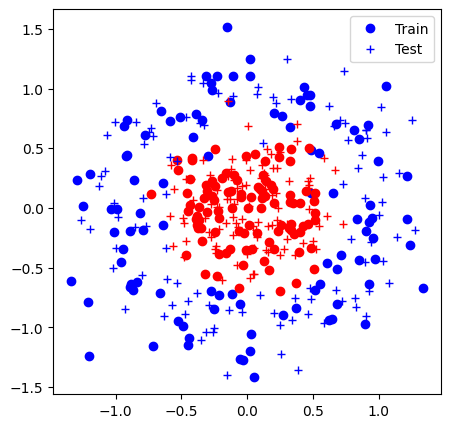

Learning Rate: 0.1, Batch Size: 10


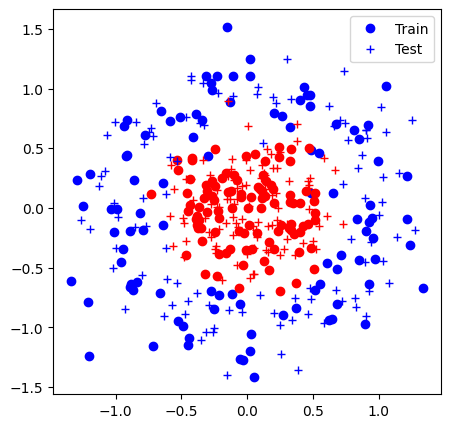

Learning Rate: 0.1, Batch Size: 5


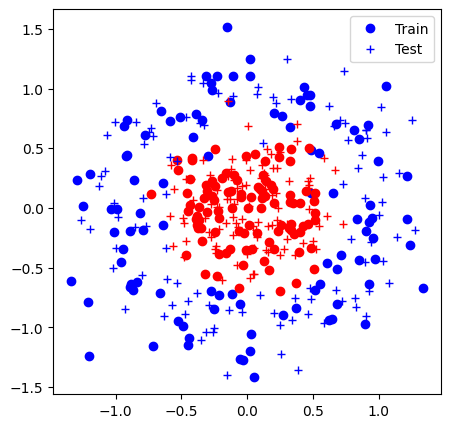

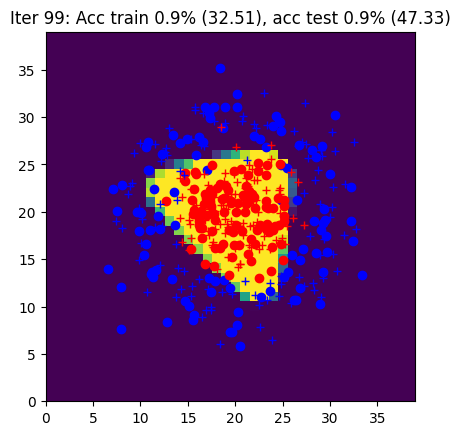

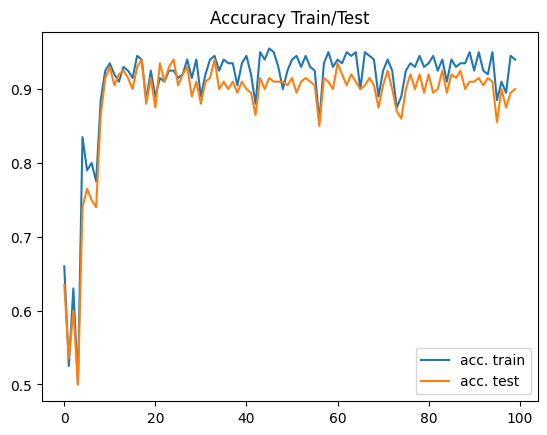

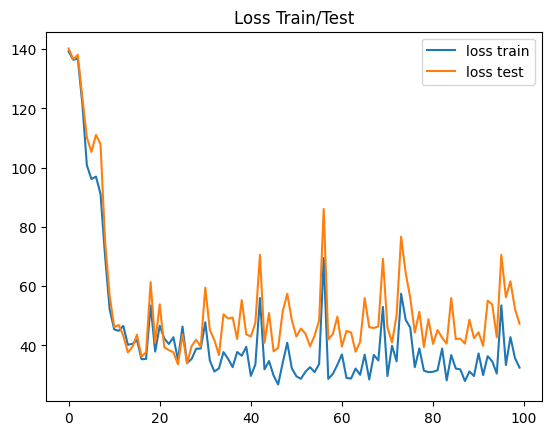

In [ ]:
learning_rates = [0.01, 0.1] # Different learning rates to test
batch_sizes = [20, 10, 5]  # Different batch sizes to test

results = {}

# Loop through each combination of learning rate and batch size
for eta in learning_rates:
    for Nbatch in batch_sizes:
      print(f"Learning Rate: {eta}, Batch Size: {Nbatch}")

      # init
      data = CirclesData()
      data.plot_data()
      N = data.Xtrain.shape[0]
      nx = data.Xtrain.shape[1]
      nh = 10
      ny = data.Ytrain.shape[1]
      nb_epoch = 100  # Number of epochs

      params = init_params(nx, nh, ny)

      curves = [[],[], [], []]

      # Loop through each epoch
      for iteration in range(nb_epoch):

        # permute
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        # batches
        for j in range(N // Nbatch):

            indsBatch = range(j * Nbatch, (j+1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # write the optimization algorithm on the batch (X,Y)
            # using the functions: forward, loss_accuracy, backward, sgd
            Yhat, outputs= forward(params, X)

            L, acc= loss_accuracy(Yhat, Y)

            grads= backward(params, outputs, Y)
            params= sgd(params, grads, eta)


        Yhat_train, _ = forward(params, data.Xtrain)
        Yhat_test, _ = forward(params, data.Xtest)
        Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
        Ygrid, _ = forward(params, data.Xgrid)

        title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
        # print(title)
        #data.plot_data_with_grid(Ygrid, title)

        curves[0].append(acctrain)
        curves[1].append(acctest)
        curves[2].append(Ltrain)
        curves[3].append(Ltest)

      # Save results
      results[(eta, Nbatch)] = curves

data.plot_data_with_grid(Ygrid, title)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Accuracy Train/Test")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss Train/Test")
plt.legend()
plt.show()

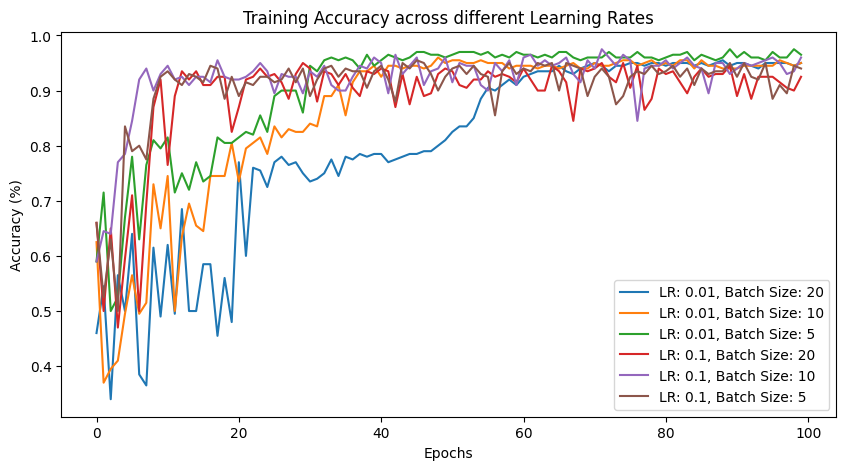

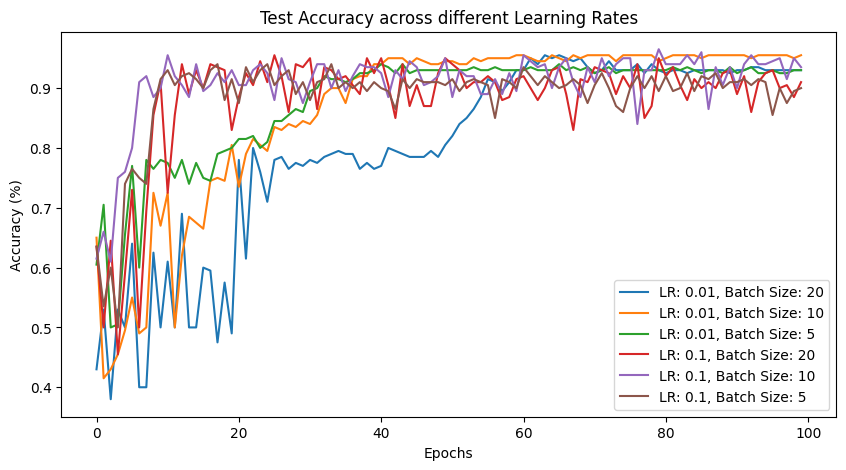

In [ ]:
# Comparing all learning rates and batch sizes on the same graph

# Train Accuracy
plt.figure(figsize=(10, 5))

for (eta, Nbatch), curves in results.items():
    epochs = range(len(curves[0]))  # Number of recorded epochs
    plt.plot(epochs, curves[0], label=f"LR: {eta}, Batch Size: {Nbatch}")

plt.title("Training Accuracy across different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# Test accuracy
plt.figure(figsize=(10, 5))

for (eta, Nbatch), curves in results.items():
    epochs = range(len(curves[1]))  # Number of recorded epochs
    plt.plot(epochs, curves[1], label=f"LR: {eta}, Batch Size: {Nbatch}")

plt.title("Test Accuracy across different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()



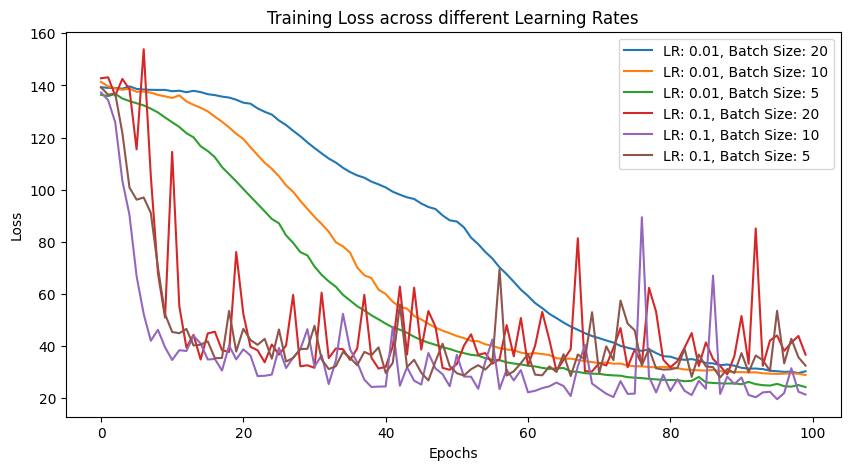

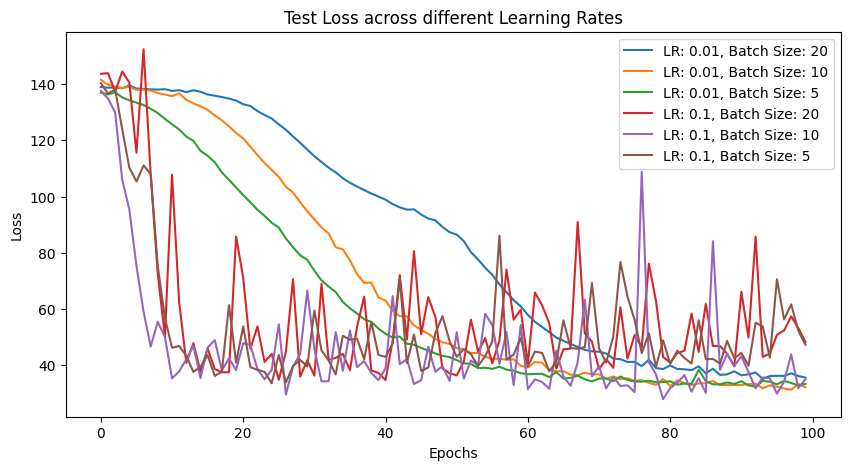

In [ ]:
# Comparing all losses on the same graph

# Train loss
plt.figure(figsize=(10, 5))

for (eta, Nbatch), curves in results.items():
    epochs = range(len(curves[2]))  # Number of recorded epochs
    plt.plot(epochs, curves[2], label=f"LR: {eta}, Batch Size: {Nbatch}")

plt.title("Training Loss across different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test loss
plt.figure(figsize=(10, 5))

for (eta, Nbatch), curves in results.items():
    epochs = range(len(curves[3]))  # Number of recorded epochs
    plt.plot(epochs, curves[3], label=f"LR: {eta}, Batch Size: {Nbatch}")

plt.title("Test Loss across different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


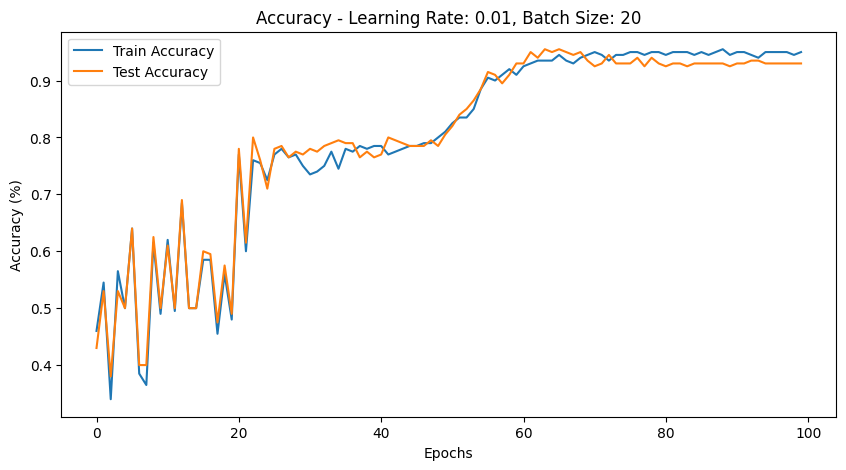

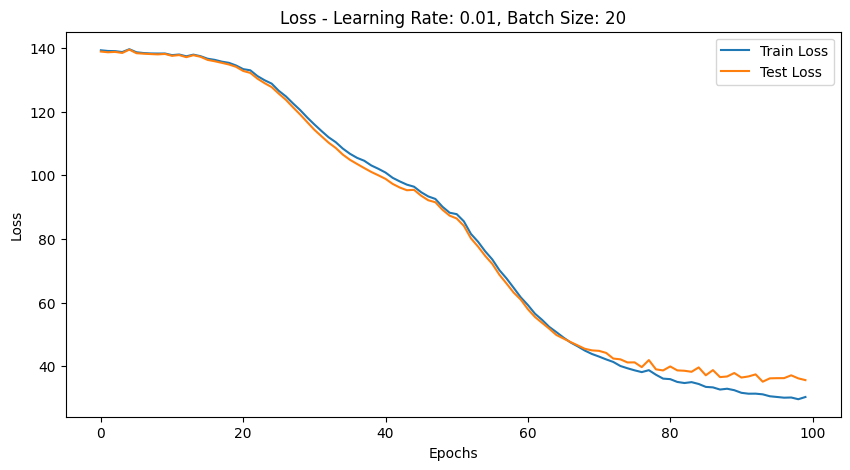

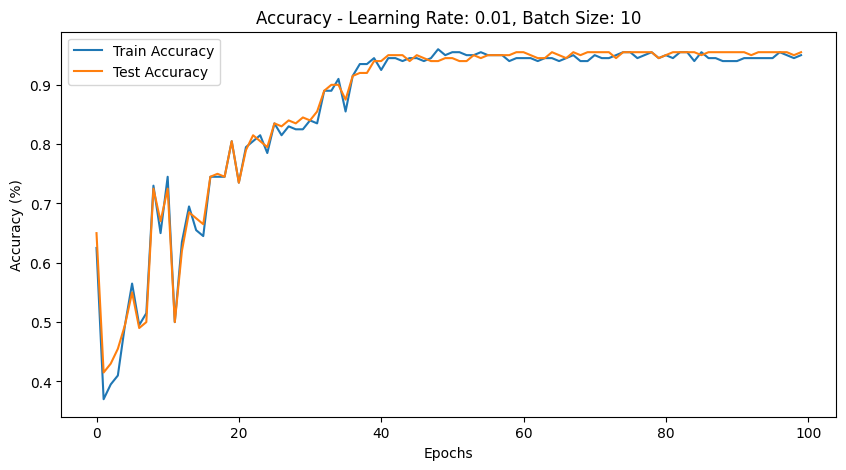

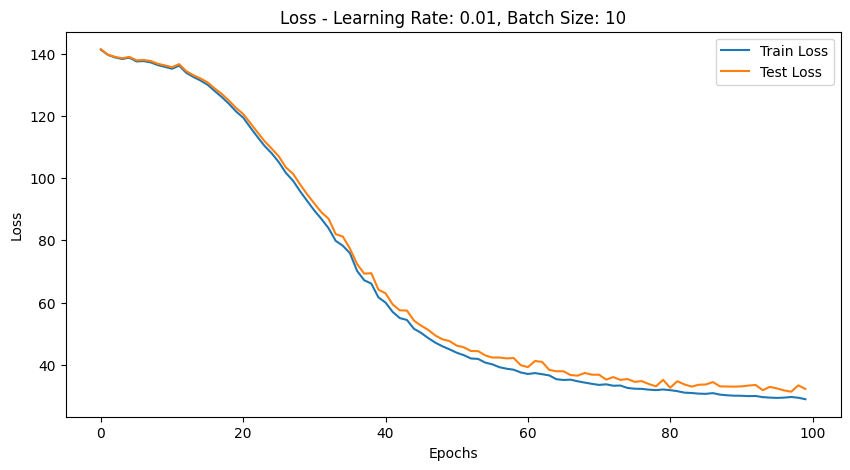

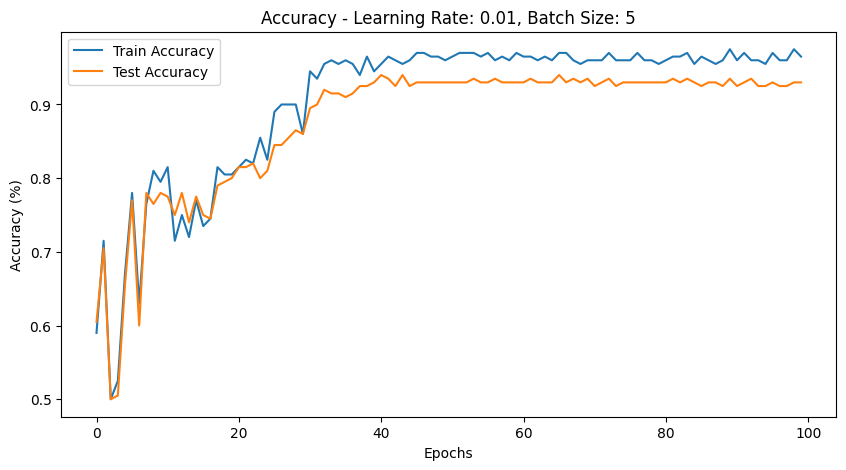

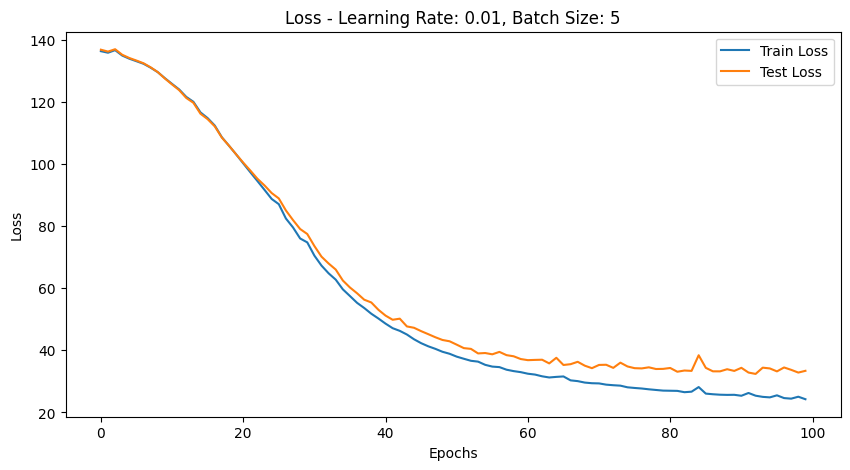

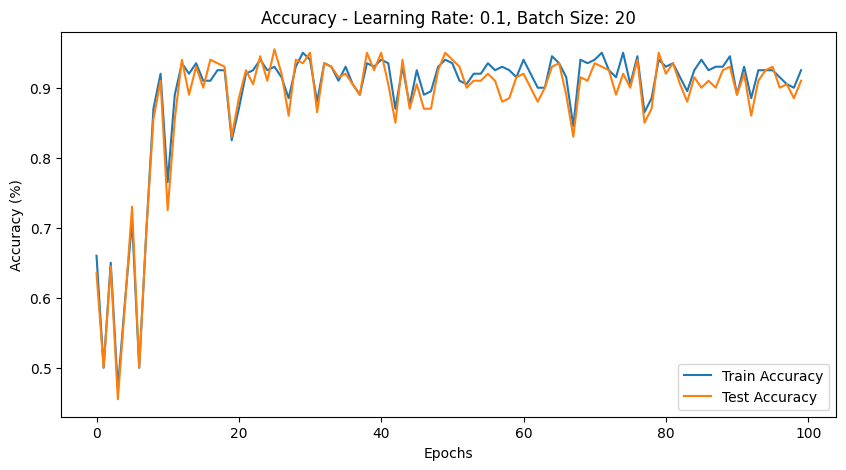

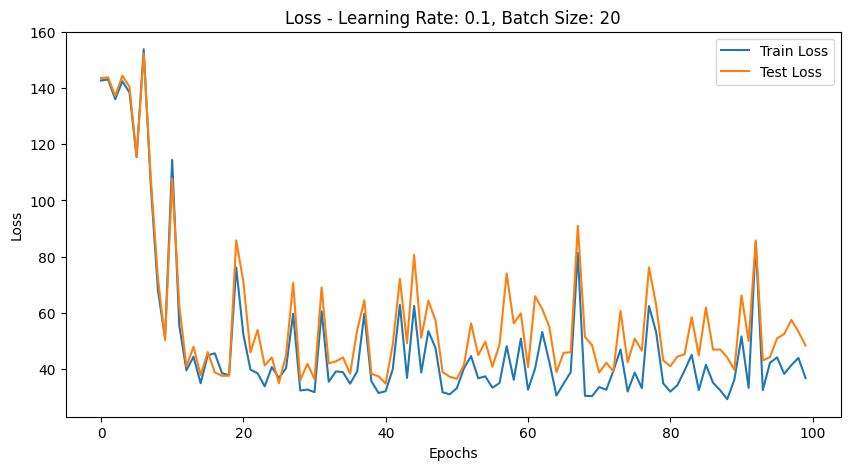

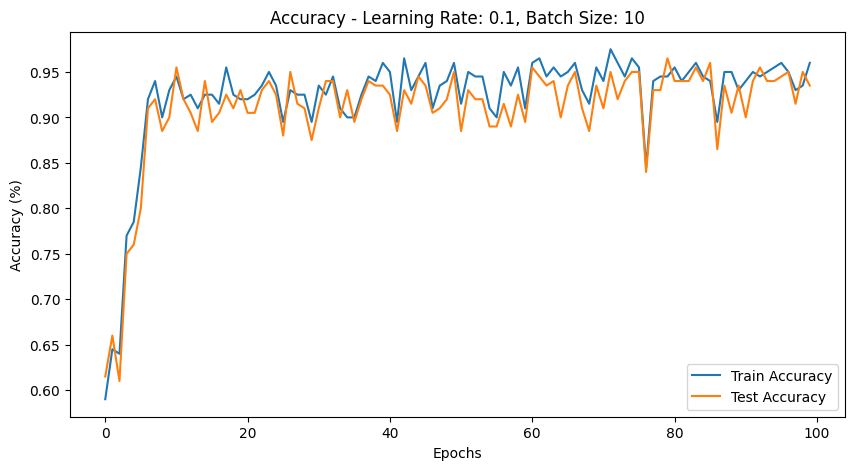

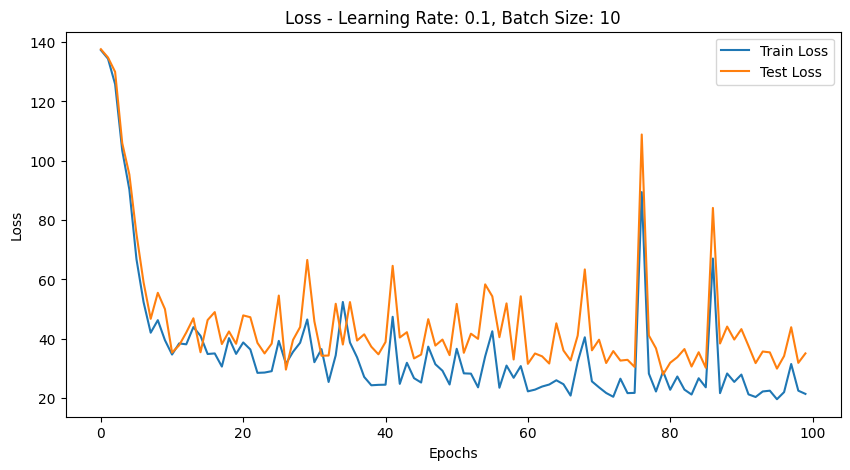

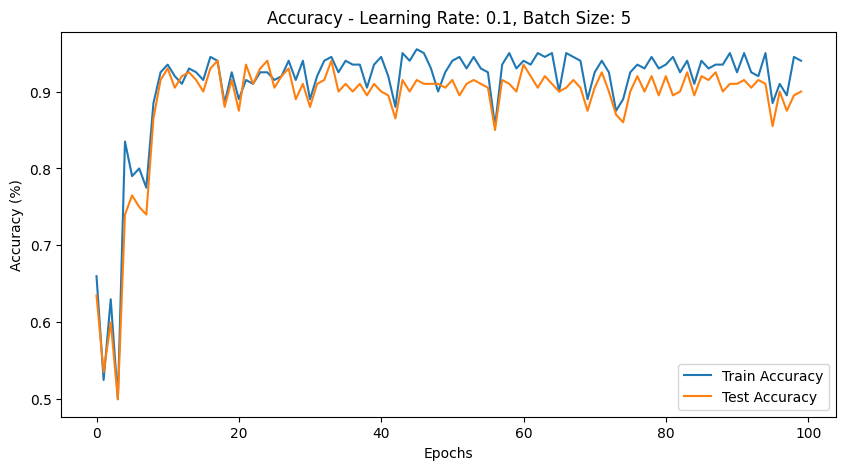

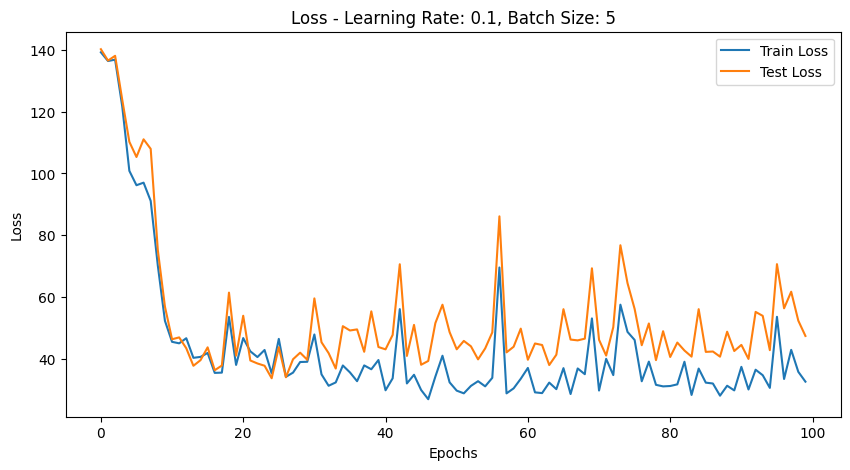

In [ ]:
# Plot train/test results for each configuration
for (eta, Nbatch), curves in results.items():
    epochs = range(len(curves[0]))

    # Plot accuracy (train and test)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, curves[0], label="Train Accuracy")
    plt.plot(epochs, curves[1], label="Test Accuracy")
    plt.title(f"Accuracy - Learning Rate: {eta}, Batch Size: {Nbatch}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

    # Plot loss (train and test)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, curves[2], label="Train Loss")
    plt.plot(epochs, curves[3], label="Test Loss")
    plt.title(f"Loss - Learning Rate: {eta}, Batch Size: {Nbatch}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


# Part 2 : Simplification of the backward pass with `torch.autograd`



In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    # fill values for Wh, Wy, bh, by
    # activate autograd on the network weights
    params["Wh"] = torch.randn((nh, nx)) *0.3 # we multiply by 0.3 to have a std of 0.3
    params["Wh"].requires_grad=True

    params["Wy"] = torch.randn((ny, nh)) *0.3
    params["Wy"].requires_grad=True

    params["bh"] = torch.randn((1,nh)) *0.3
    params["bh"].requires_grad=True

    params["by"] = torch.randn((1,ny)) *0.3
    params["by"].requires_grad=True

    return params

The function `forward` remains unchanged from previous part.

The function `backward` is no longer used because of "autograd".

In [ ]:
def sgd(params, eta):

    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    with torch.no_grad() :
      params["Wh"] -= eta * params["Wh"].grad
      params["Wh"].grad.zero_() # resets the gradient accumulator to zero

      params["Wy"] -= eta * params["Wy"].grad
      params["Wy"].grad.zero_() # resets the gradient accumulator to zero

      params["bh"] -= eta * params["bh"].grad
      params["bh"].grad.zero_() # resets the gradient accumulator to zero

      params["by"] -= eta * params["by"].grad
      params["by"].grad.zero_() # resets the gradient accumulator to zero

    return params

## Global learning procedure with autograd

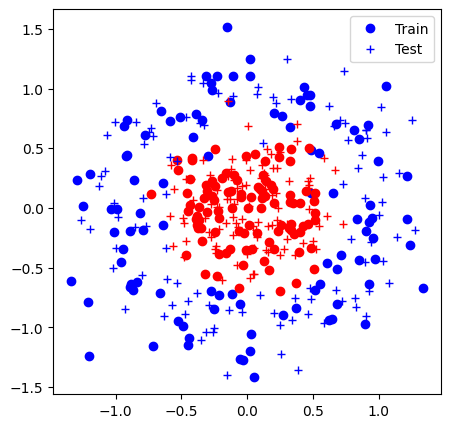

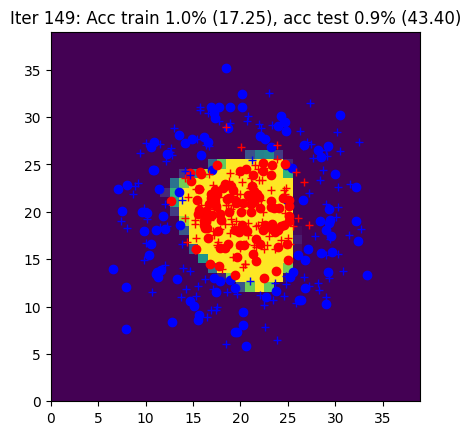

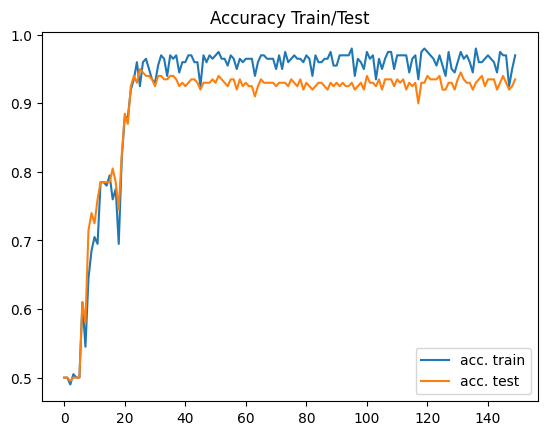

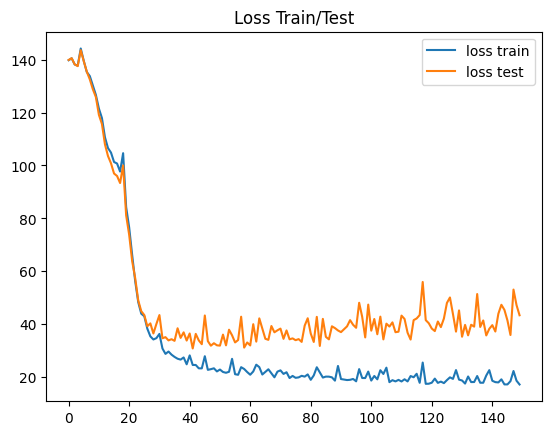

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03
nb_epoch=150

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(nb_epoch):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, sgd
        # and the backward function with autograd
        Yhat, outputs= forward(params, X)

        L, acc= loss_accuracy(Yhat, Y)
        L.backward()

        params= sgd(params, eta)

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)


    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    # print(title)
    # detach() is used to remove the predictions from the computational graph in autograd
    # data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain.item())
    curves[1].append(acctest.item())
    curves[2].append(Ltrain.item())
    curves[3].append(Ltest.item())

data.plot_data_with_grid(Ygrid.detach(), title)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Accuracy Train/Test")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss Train/Test")
plt.legend()
plt.show()

In [ ]:
print( "Accuracy train : ", curves[0][-1]*100, "%")
print( "Accuracy test : ", curves[1][-1]*100, "%")
print( "Loss train : ", curves[2][-1])
print( "Loss test : ", curves[3][-1])

Accuracy train :  97.00000286102295 %
Accuracy test :  93.50000023841858 %
Loss train :  17.25231170654297
Loss test :  43.39995193481445


# Part 3 : Simplification of the forward pass with `torch.nn`

`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.

In [ ]:
def init_model(nx, nh, ny):
 model = torch.nn.Sequential(
 torch.nn.Linear(nx, nh),
 torch.nn.Tanh(),
 torch.nn.Linear(nh, ny),
 )
 loss = torch.nn.CrossEntropyLoss()
 return model, loss

In [ ]:
def loss_accuracy(loss, Yhat, Y):
    L = 0
    acc = 0

    # Loss
    L=loss(Yhat, Y)

    # Accuracy
    _, indsYhat = torch.max (Yhat, 1) # dim=1; so we get the same number of exemples
    _, indsY = torch.max (Y, 1)
    acc = torch.sum(indsYhat==indsY)/indsYhat.shape[0]

    return L, acc

In [ ]:
 def sgd(model, eta):
  with torch.no_grad():
    for param in model.parameters():
      if param.grad != None :
        param -= eta * param.grad
    model.zero_grad()
  return model

## Global learning procedure with autograd and `torch.nn`

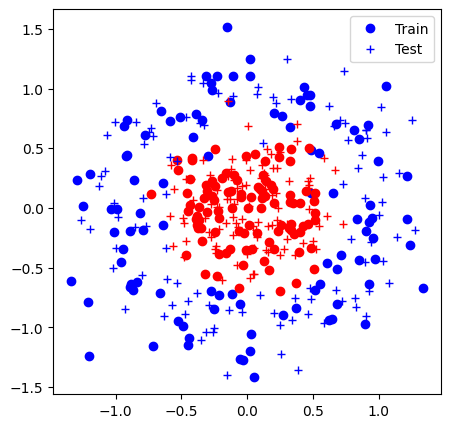

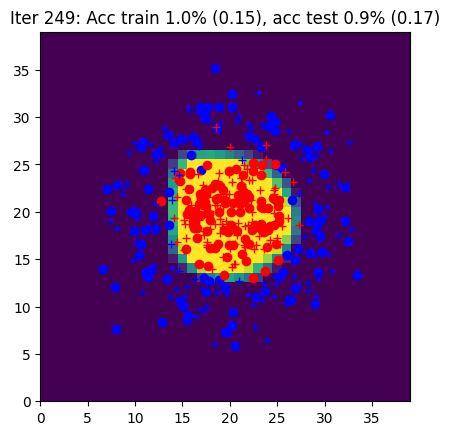

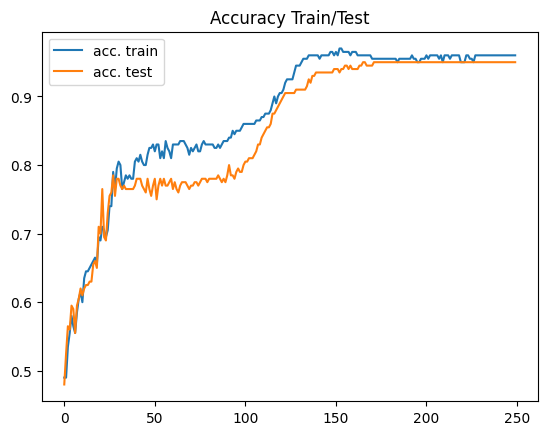

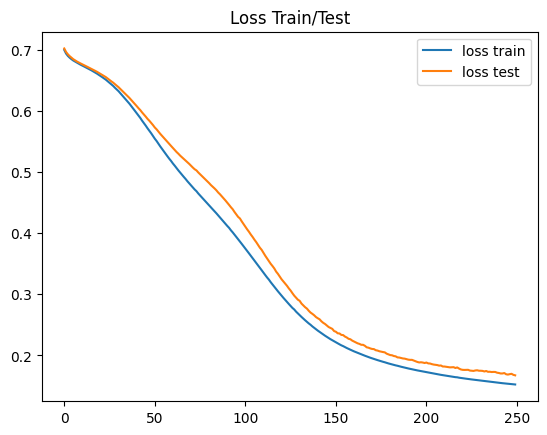

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03
nb_epoch=250

model, loss = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(nb_epoch):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy, sgd
        # the forward with the predict method from the model
        # and the backward function with autograd
        Yhat = model(X)
        L = loss(Yhat, Y) # We use ytild becose the CE loss in pytorch adds a softmax layer by default
        L.backward()

        model= sgd(model, eta)


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    # print(title)

    curves[0].append(acctrain.item())
    curves[1].append(acctest.item())
    curves[2].append(Ltrain.item())
    curves[3].append(Ltest.item())

data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Accuracy Train/Test")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss Train/Test")
plt.legend()

In [ ]:
print( "Accuracy train : ", curves[0][-1]*100, "%")
print( "Accuracy test : ", curves[1][-1]*100, "%")
print( "Loss train : ", curves[2][-1])
print( "Loss test : ", curves[3][-1])

Accuracy train :  95.99999785423279 %
Accuracy test :  94.9999988079071 %
Loss train :  0.1525111347436905
Loss test :  0.1674753576517105


# Part 4 : Simplification of the SGD with `torch.optim`

In [ ]:
def init_model(nx, nh, ny, eta):

    model = torch.nn.Sequential(
    torch.nn.Linear(nx, nh),
    torch.nn.Tanh(),
    torch.nn.Linear(nh, ny))

    loss = torch.nn.CrossEntropyLoss()

    optim = torch.optim.SGD(model.parameters(), lr=eta)

    return model, loss, optim

The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after.

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

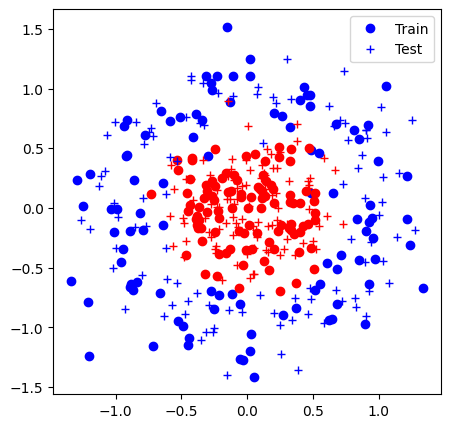

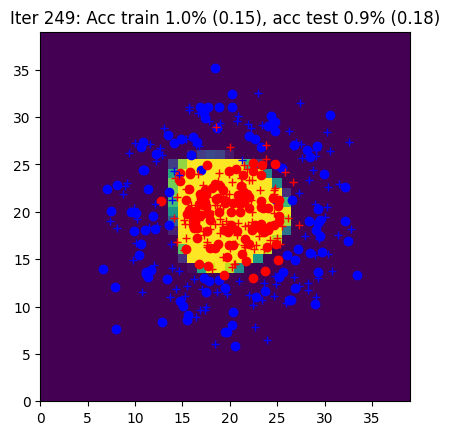

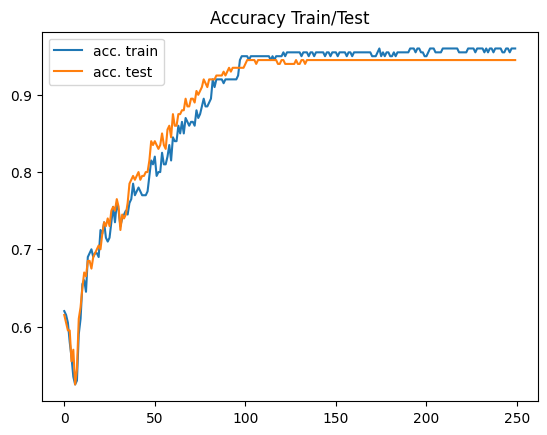

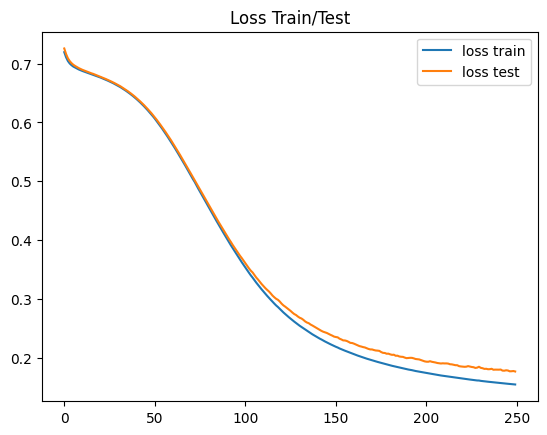

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03
nb_epoch=250
model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(nb_epoch):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an optimization step
        Yhat = model(X)
        L = loss(Yhat, Y) # We use ytild because the CE loss in pytorch adds a softmax layer by default

        optim.zero_grad()
        L.backward()
        optim.step()


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    # print(title)

    curves[0].append(acctrain.item())
    curves[1].append(acctest.item())
    curves[2].append(Ltrain.item())
    curves[3].append(Ltest.item())

data.plot_data_with_grid(Ygrid.detach(), title)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Accuracy Train/Test")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss Train/Test")
plt.legend()
plt.show()

In [ ]:
print( "Accuracy train : ", curves[0][-1]*100, "%")
print( "Accuracy test : ", curves[1][-1]*100, "%")
print( "Loss train : ", curves[2][-1])
print( "Loss test : ", curves[3][-1])

Accuracy train :  95.99999785423279 %
Accuracy test :  94.49999928474426 %
Loss train :  0.15423831343650818
Loss test :  0.17635038495063782


# Part 5 : MNIST

Apply the code from previous part code to the MNIST dataset.

In [ ]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03

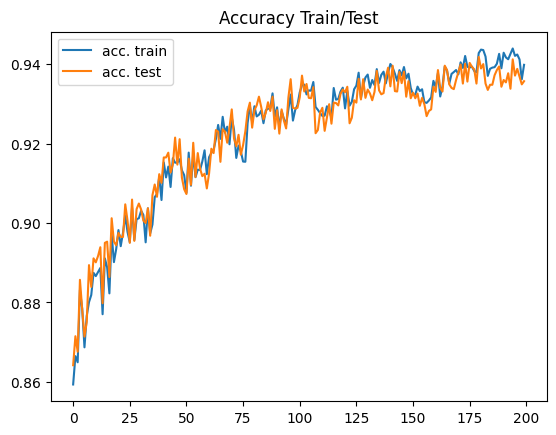

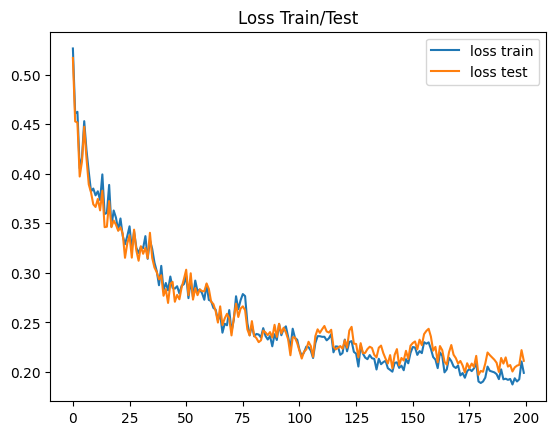

In [ ]:
nb_epoch=200
model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(nb_epoch):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an optimization step
        Yhat = model(X)
        L = loss(Yhat, Y) # We use ytild becose the CE loss in pytorch adds a softmax layer by default

        optim.zero_grad()
        L.backward()
        optim.step()


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    # Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    # print(title)

    curves[0].append(acctrain.item())
    curves[1].append(acctest.item())
    curves[2].append(Ltrain.item())
    curves[3].append(Ltest.item())

# data.plot_data_with_grid(Ygrid.detach(), title)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Accuracy Train/Test")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss Train/Test")
plt.legend()
plt.show()

In [ ]:
print( "Accuracy train : ", curves[0][-1]*100, "%")
print( "Accuracy test : ", curves[1][-1]*100, "%")
print( "Loss train : ", curves[2][-1])
print( "Loss test : ", curves[3][-1])

Accuracy train :  93.98166537284851 %
Accuracy test :  93.5699999332428 %
Loss train :  0.1991451382637024
Loss test :  0.2112739235162735


# Part 6: Bonus: SVM


Train a SVM model on the Circles dataset.

Ideas :
- First try a linear SVM (sklearn.svm.LinearSVC dans scikit-learn). Does it work well ? Why ?
- Then try more complex kernels (sklearn.svm.SVC). Which one is the best ? why ?
- Does the parameter C of regularization have an impact? Why ?

In [ ]:

############################
### Your code here   #######
### Train the SVM    #######
## See https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
## and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
############################

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC



###########################

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions, title=""):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.title(title)
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

Linear SVM

Linear SVC vs SVC

Accuracy : 53.00


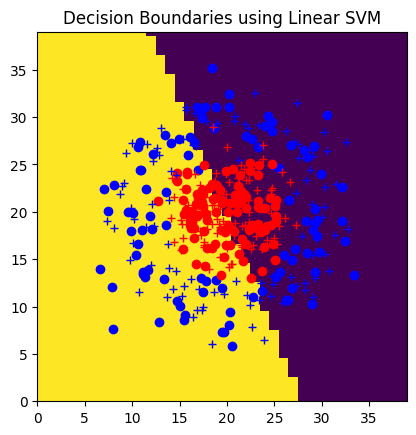

In [ ]:
lin_svm = make_pipeline(StandardScaler(), LinearSVC())
lin_svm.fit(Xtrain, Ytrain)
## Print results
Ytest_pred = lin_svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = lin_svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred, "Decision Boundaries using Linear SVM")

Linear SVC does not perform well because the data is not separable linearly. We need to project the data into a higher dimension (using a kernel) to find a hyperplane separating the two classes, which can be done using SVC.

Accuracy : 94.00


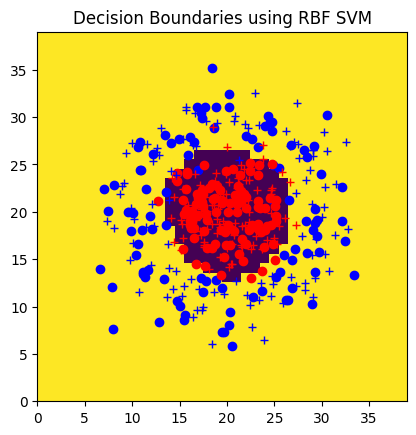

In [ ]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(Xtrain, Ytrain)
## Print results
Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred, "Decision Boundaries using RBF SVM")

Change kernel of SVC

Accuracy : 62.00


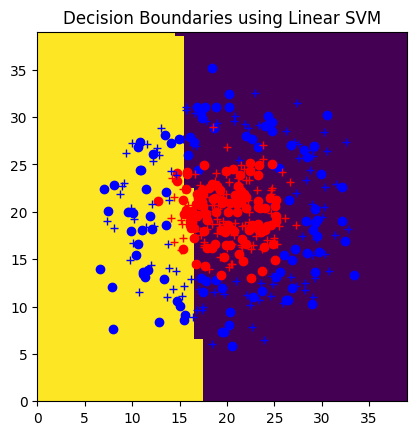

In [ ]:
svm = make_pipeline(StandardScaler(), SVC(kernel="linear", gamma='auto'))
svm.fit(Xtrain, Ytrain)
## Print results
Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred, "Decision Boundaries using Linear SVM")

The linear kernel computes the dot product (or cosine similarity) between pairs of points, which doesn’t transform the data into a higher-dimensional space. It doesn't work very well because it doesn’t help capture non-linear relationships.

Accuracy : 51.50


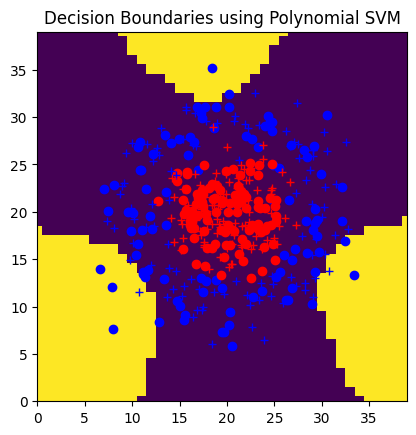

In [ ]:
svm = make_pipeline(StandardScaler(), SVC(kernel="poly", gamma='auto'))
svm.fit(Xtrain, Ytrain)
## Print results
Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred, "Decision Boundaries using Polynomial SVM")

Accuracy : 65.50


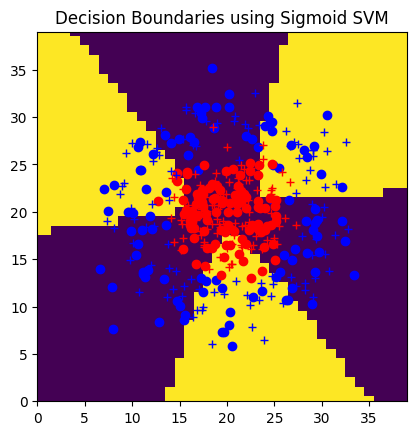

In [ ]:
svm = make_pipeline(StandardScaler(), SVC(kernel="sigmoid", gamma='auto'))
svm.fit(Xtrain, Ytrain)
## Print results
Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred, "Decision Boundaries using Sigmoid SVM")

RBF (the default kernel) is the best.

## Impact of C

Accuracy : 95.00


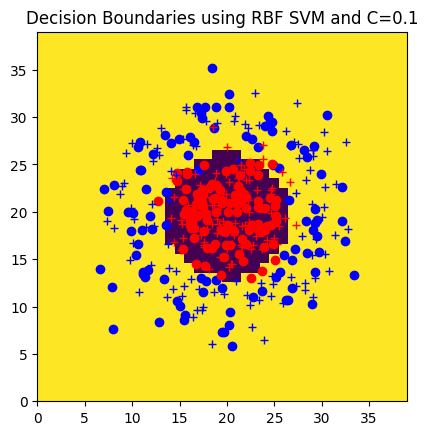

In [ ]:
svm = make_pipeline(StandardScaler(), SVC(C=0.1, gamma='auto'))
svm.fit(Xtrain, Ytrain)
## Print results
Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred, "Decision Boundaries using RBF SVM and C=0.1")

Accuracy : 93.00


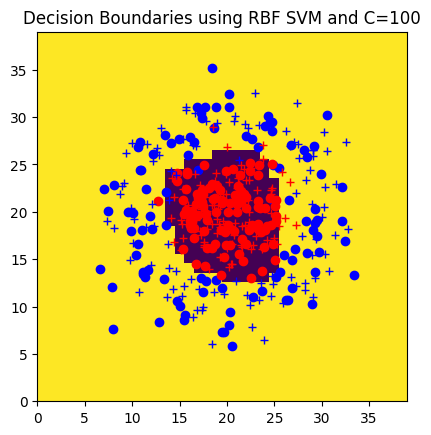

In [ ]:
svm = make_pipeline(StandardScaler(), SVC(C=100, gamma='auto'))
svm.fit(Xtrain, Ytrain)
## Print results
Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred, "Decision Boundaries using RBF SVM and C=100")

from the documentation "The strength of the regularization is inversely proportional to C"
The stronger the regularization, the more the errors will be penalized and the svm will try to classify the points as good as possible.
With higher values of C, we had less accuracy because the model was more tolerant to errors.

Global comparaison

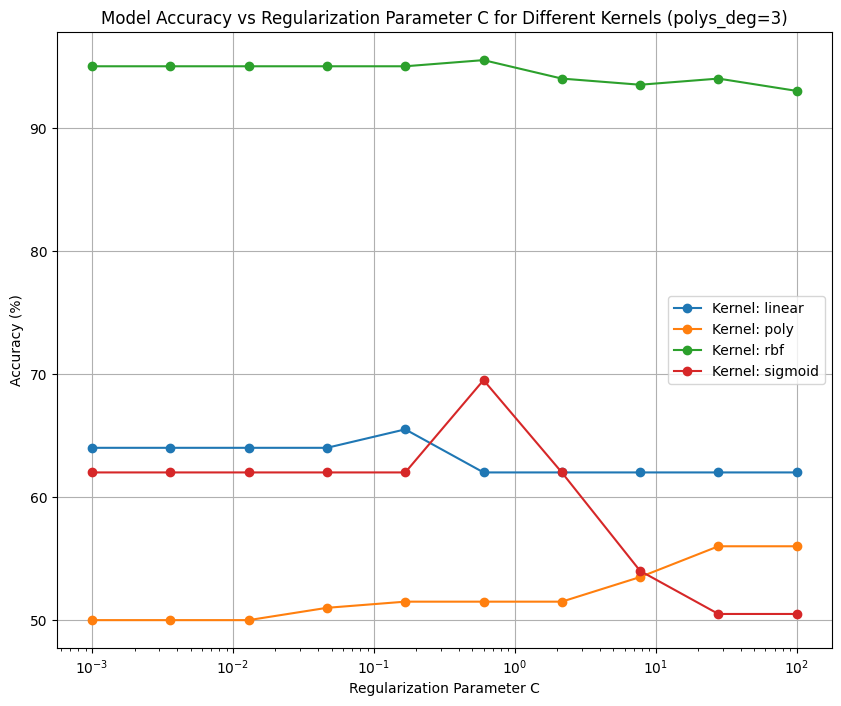

In [ ]:
C_values = np.logspace(-3, 2, 10)  # Vary the values of C from 0.001 to 100
kernels = ['linear', 'poly', 'rbf', 'sigmoid']  # Kernels to test

plt.figure(figsize=(10, 8))

for kernel in kernels:
    accuracies = []
    for C in C_values:
        # Create and train the SVM model with the specified kernel and C value
        svm = make_pipeline(StandardScaler(), SVC(C=C, kernel=kernel, gamma='auto'))
        svm.fit(Xtrain, Ytrain)
        Ytest_pred = svm.predict(Xtest)

        # Calculate accuracy
        accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
        accuracies.append(accuracy * 100)  # Convert to percentage

    # Plot accuracy for each kernel type
    plt.plot(C_values, accuracies, marker='o', label=f'Kernel: {kernel}')

plt.xscale('log')
plt.xlabel("Regularization Parameter C")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy vs Regularization Parameter C for Different Kernels (polys_deg=3)")
plt.legend()
plt.grid(True)
plt.show()


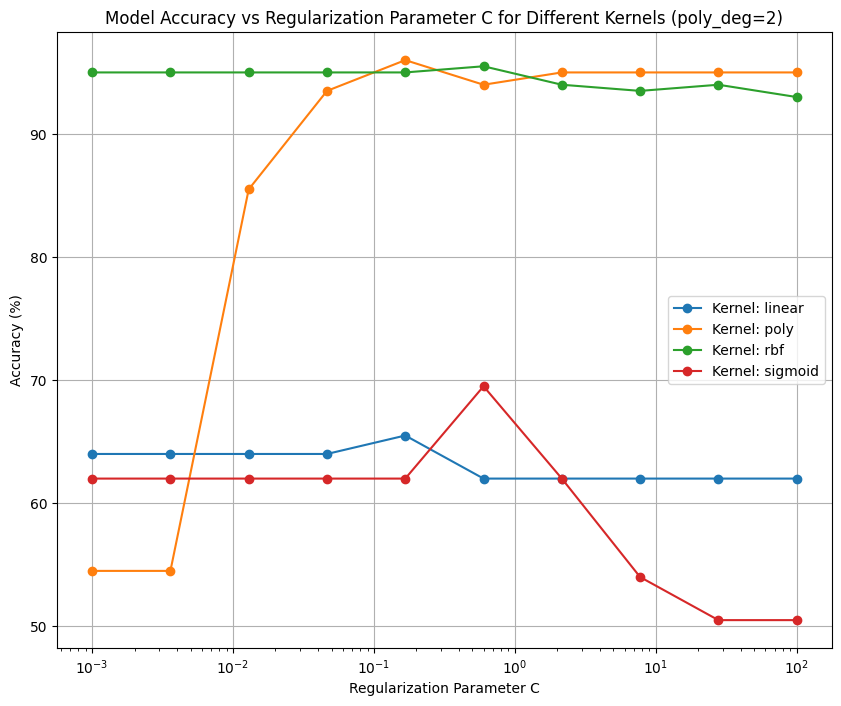

In [ ]:
C_values = np.logspace(-3, 2, 10)  # Vary the values of C from 0.001 to 100
kernels = ['linear', 'poly', 'rbf', 'sigmoid']  # Kernels to test

plt.figure(figsize=(10, 8))

for kernel in kernels:
    accuracies = []
    for C in C_values:
        # Create and train the SVM model with the specified kernel and C value
        svm = make_pipeline(StandardScaler(), SVC(C=C, kernel=kernel, gamma='auto', degree=2)) # Feature engineering is important when it comes to polynomial svm
        svm.fit(Xtrain, Ytrain)
        Ytest_pred = svm.predict(Xtest)

        # Calculate accuracy
        accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
        accuracies.append(accuracy * 100)  # Convert to percentage

    # Plot accuracy for each kernel type
    plt.plot(C_values, accuracies, marker='o', label=f'Kernel: {kernel}')

plt.xscale('log')
plt.xlabel("Regularization Parameter C")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy vs Regularization Parameter C for Different Kernels (poly_deg=2)")
plt.legend()
plt.grid(True)
plt.show()
